In [6]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Distances
using Random
using Plots
using VectorizedRoutines;

In [186]:
#Hyperparameters
n = 10
N = 300
σₐ = 0.001
α = 0.9
σₖ = sqrt(1/α)
bound = 1

k_range = 100
k_list = [i for i=1:100] #November 3
#k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
k_list_lite = [i for i in 1:k_range]
k_real = 70
k = k_real;

#Functions
function plot_data(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha)
    #PyPlot.colorbar()
end

function plot_contour(data, scores, alpha=1.0)
    PyPlot.contour(data[:,1],data[:,2],c=scores)
end

function sample_data(x, y, n=N)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

mₖ(k) = k*4 + 1;

In [42]:
#Generative Interpolator Network

#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    #if(typeof(x) == Float64)
        #x = [x]
    #end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, sigmoid),
               Dense(W₂, b₂))
    return nn(x)
end;

#Create a Random Network
@gen function generator(x::Array{Float64}, k=12)
    α = 0.9 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k
    print(k)
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    #scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    #scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([0.001 for i=1:length(x[1,:])])), (:y))
    
end;

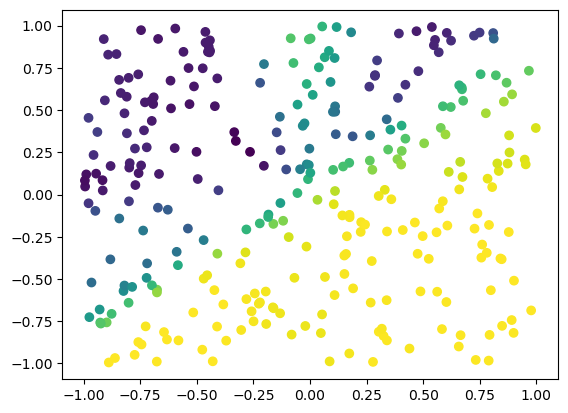

70

PyObject <matplotlib.collections.PathCollection object at 0x7fc055815490>

In [251]:
#Generate Network Parameters and Corresponding Curve
obs = choicemap()::ChoiceMap
x_raw = rand(Uniform(-bound,bound),(N,2))
x = transpose(x_raw)
data = x
data_raw = x_raw

(trace,) = generate(generator, (x, k_real), obs)

Wₕ = trace[:Wₕ]
Wₒ = trace[:Wₒ]
bₕ = trace[:bₕ]
bₒ = trace[:bₒ]

#y_real = Flux.σ.(G(x.*100000,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])
y_real = Flux.σ.(G(x.*10,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])
#print(y_real)

y_fake = rand(Uniform(0,1),(N))
#y_real = y_fake
plot_data(x_raw,y_real)

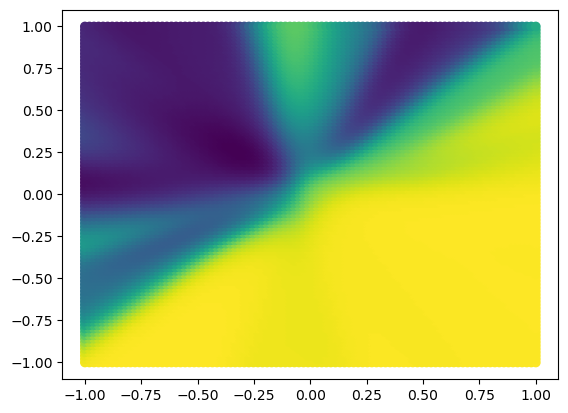

PyObject <matplotlib.collections.PathCollection object at 0x7fc05574a850>

In [253]:
function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-1.0,1.0)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = Flux.σ.(G(grid2.*10,Wₕ,bₕ,Wₒ,bₒ,k_real))[1,:]
plot_data(grid_raw, z)

In [254]:
#Classifier Network Tries to Learn the Generator Network

#@dist k_count() = categorical([1/length(k_list) for i=1:length(k_list)]) + 1

@gen function classifier(x::Array{Float64})
    α = 0.9 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    #k_real = k_list[k]
    k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k_list[k]
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    scores = Flux.σ.(scores)
    
    #Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([0.002 for i=1:length(x[1,:])])), (:y))
    
    return y
end;

classifier(x);

In [259]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs = obs_master;

obs2 = choicemap()::ChoiceMap
obs2[:y] = y_real

#println(y_real)
#println(y_fake)

(trace1,) = generate(classifier, (x,), obs)
(trace2,) = generate(classifier, (x,), obs2)

score1 = get_score(trace1)
score2 = get_score(trace2)

println(score1)
println(score2)
println(score2 - score1)

-39001.19431645354
-35554.014522047284
3447.1797944062564


In [260]:
#Register Observed Data
x_samp, y_samp = x_raw, y_real
x_samp = transpose(x_samp)
size(x_samp)
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master
scores = []
distances = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = Flux.σ.(G(x,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k))
best_dist = euclidean(best_pred_y, y_real)

8.217757175014974

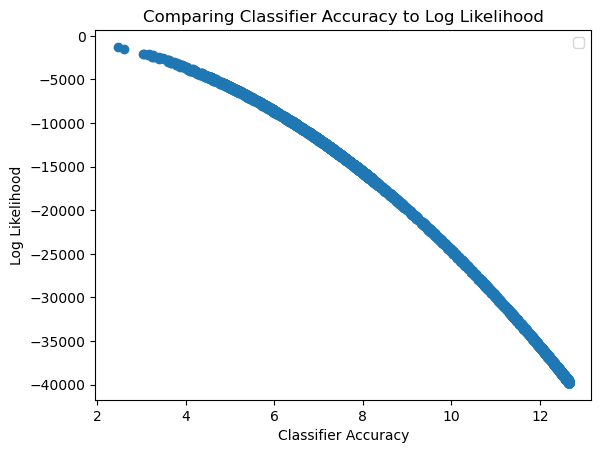

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7fc05fbe3c90>

In [261]:
#Plot of Log Likelihood Scores
#x_samp, y_samp = sample_data(x, y_real)
x_samp, y_samp = x_raw, y_real
x_samp = transpose(x_samp)
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master;

scores = []
distances = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = Flux.σ.(G(x,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k))
best_dist = euclidean(best_pred_y, y_real)

function likelihood(best_trace, best_dist, best_score, best_k)
    #x_samp, y_samp = sample_data(x, y_real)
    obs = obs_master;
    obs[:k] = best_trace[:k]
    (trace,) = generate(classifier, (x_samp,), obs)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    #print(k)
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))

    #dist = sqrt(sum((pred_y .- y_real) .^ 2))
    dist = euclidean(pred_y, y_real)
    score = get_score(trace)
    #println(score)
    if score > get_score(best_trace)
        best_dist = dist
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_k = best_trace[:k]
    end
    #push!(best_ks,best_k)
    push!(scores,score)
    push!(distances,dist)
    push!(ks, k)
    #println(best_score)
    return(best_trace, best_dist, best_score, best_k)
end

#Testing specific k value
obs = obs_master
obs[:k] = 30
(best_trace2,) = generate(classifier, (x_samp,), obs)
for i=1:2000
    best_trace2, best_dist, best_score, best_k = likelihood(best_trace2, best_dist, best_score, best_k)
    push!(best_ks, best_k)
    #println(get_score(best_trace2))
end

obs = obs_master
obs[:k] = 70
(best_trace3,) = generate(classifier, (x_samp,), obs)
for i=1:2000
    best_trace3, best_dist, best_score, best_k = likelihood(best_trace3, best_dist, best_score, best_k)
    push!(best_ks, best_k)
    #println(get_score(best_trace3))
end

#plt.xlim(0,200)
#plt.ylim(-6000,0)
PyPlot.scatter(distances, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.legend()

In [262]:
#Compare Number of Nodes in the Network
println(get_score(best_trace2))
println(get_score(best_trace3))

-2047.8319787044027
-1266.4567905447925


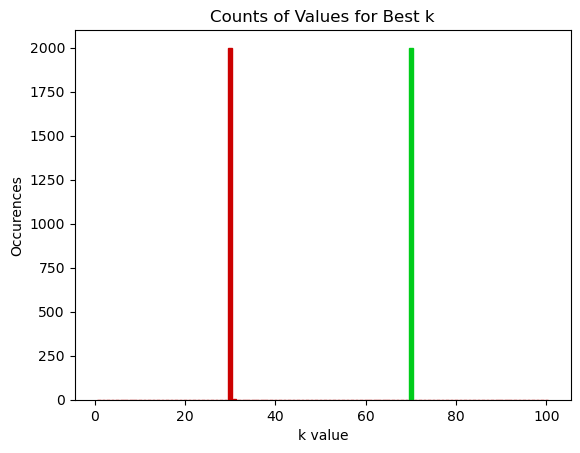

31
-14301.595656935677


In [263]:
#print(best_ks)
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([best_ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=PyPlot.bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[k_real].set_color([0.0,0.8,0.1])
println(best_trace[:k])
println(get_score(best_trace))
plt.title("Counts of Values for Best k")
plt.xlabel("k value")
plt.ylabel("Occurences");

In [264]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(trace)
    current_k = trace[:k]
    if current_k == last(k_list)
        new_trace = death(trace)
    elseif current_k == k_list[1]
        new_trace = birth(trace)
    else
        new_trace = bernoulli(0.5) ? birth(trace) : death(trace)
    end
    return new_trace    
end

@gen function birth(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    #new_k = previous_k + 1
    difference = abs(new_k - previous_k)
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_samp
    obs_new[:Wₕ] = vcat(Wₕ,[normal(0,σₖ) for i=1:(2*difference)])
    obs_new[:Wₒ] = vcat(Wₒ,[normal(0,σₖ) for i=1:difference])
    obs_new[:bₕ] = vcat(bₕ,[normal(1,σₖ) for i=1:difference])
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace

end

@gen function death(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k - 1]
    #new_k = previous_k - 1
    difference = abs(previous_k - new_k)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_samp
    obs_new[:Wₕ] = Wₕ[1:new_k*2]
    obs_new[:Wₒ] = Wₒ[1:new_k]
    obs_new[:bₕ] = bₕ[1:new_k]
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace
end;

In [266]:
traces = []
acc = []
acc_a = []
acc_w = []
ks = []
epss = []

function within_dimension(trace, iters)
    for i=1:iters
        #current_k = obs[:k]
        #println("w: $current_k")
        eps = uniform(0.0015,0.02)
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=eps, check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
        push!(acc_w, accepted)
        #accepted && println("Within accepted")
    end
    return trace
end

function across_dimension(trace, iters, obs)
    
    new_trace = birth_or_death(trace)
    score_test = get_score(new_trace)
    
    test = true
    for i=1:iters
        eps = uniform(0.0015,0.02)
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=15, eps=eps, check=false, observations=obs)
        accepted && (test = false)
        if get_score(new_trace) < score_test
            push!(epss,eps)
            #println("EPS: $eps")
        end
    end
    #test && println("Nothing accepted")
    
    
    score1 = get_score(trace)
    score2 = get_score(new_trace)
    
    logscore = (score2 - score1)
    score = exp(logscore)
    #println(score)
    println("Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        #println("New k accepted! Current k: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_a, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        #x_samp, y_samp = sample_data(x, y_real)
        #x_samp = transpose(x_samp)
        obs_master = choicemap()::ChoiceMap
        obs_master[:y] = y_samp
        obs = obs_master;
        if i%100 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            println("Epoch $i Across Acceptance Prob: $(sum(acc_a)/length(acc_a))")
            #print(obs[:k])
        end
        
        if rand(Uniform(0,1)) > 0.5
            (trace, k) = across_dimension(trace, 10, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
runs = 10000
#starting_trace = best_trace

#x_samp, y_samp = sample_data(x, y_real)
#x_samp = transpose(x_samp)
x_samp, y_samp = x, y_real
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master
(starting_trace,) = generate(classifier, (x_samp,), obs)
#starting_trace = best_trace2
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,runs);

Beginning RJMCMC. Starting k: 9
Old Trace: -2497.408969237147; Pre-HMC: -11682.889515438808; Post-HMC: -428.2035130187418
Old Trace: -428.2035130187418; Pre-HMC: -7112.899924063189; Post-HMC: -404.59835763237015
Old Trace: -404.59835763237015; Pre-HMC: -5127.488584891537; Post-HMC: -429.32403176459013
Old Trace: -404.59835763237015; Pre-HMC: -5127.488584891537; Post-HMC: -352.11583533501295
Old Trace: -352.11583533501295; Pre-HMC: -10521.29936649849; Post-HMC: -452.1913731750446
Old Trace: -352.11583533501295; Pre-HMC: -9104.732985279537; Post-HMC: -228.0453420795497
Old Trace: -215.1243471948351; Pre-HMC: -2110.6378935515386; Post-HMC: -414.63364394039576
Old Trace: -193.90174414347825; Pre-HMC: -3146.7797810013035; Post-HMC: 48.095908602599366
Old Trace: 50.1461864399073; Pre-HMC: -4983.158154303879; Post-HMC: -190.6161111979131
Old Trace: 50.1461864399073; Pre-HMC: -9775.596487638944; Post-HMC: 2.008603886812864
Old Trace: 77.71210522919628; Pre-HMC: -10677.285564549018; Post-HMC: 1

Old Trace: 274.03760861753796; Pre-HMC: -1266.536568532338; Post-HMC: 253.92546003545726
Old Trace: 274.03760861753796; Pre-HMC: -1266.536568532338; Post-HMC: 254.96153071716353
Old Trace: 275.35304976945815; Pre-HMC: -6038.669789029273; Post-HMC: 52.67113333910396
Old Trace: 275.35304976945815; Pre-HMC: -1178.6948250311648; Post-HMC: 253.74354795982362
Old Trace: 273.36966111936067; Pre-HMC: -5788.1922040953095; Post-HMC: -661.6269415715848
Old Trace: 273.36966111936067; Pre-HMC: -1314.294937414605; Post-HMC: 251.76925065886957
Old Trace: 273.36966111936067; Pre-HMC: -1314.294937414605; Post-HMC: 263.20492647421946
Old Trace: 273.36966111936067; Pre-HMC: -1314.294937414605; Post-HMC: 224.01253021507762
Old Trace: 273.36966111936067; Pre-HMC: -6195.306067501897; Post-HMC: -1.4877914273343436
Old Trace: 275.57045648819724; Pre-HMC: -1567.6880996734294; Post-HMC: 219.4951428328849
Old Trace: 275.57045648819724; Pre-HMC: -1567.6880996734294; Post-HMC: 248.4529477488237
Old Trace: 277.1750

Old Trace: 282.5669805705519; Pre-HMC: -8234.559575375153; Post-HMC: -497.67792012409313
Old Trace: 282.5669805705519; Pre-HMC: -7592.609709423143; Post-HMC: -175.20466288272144
Old Trace: 282.5669805705519; Pre-HMC: -6252.281478303159; Post-HMC: -1943.4333715797588
Old Trace: 282.5669805705519; Pre-HMC: -7585.949270009578; Post-HMC: -243.54825642074118
Old Trace: 282.5669805705519; Pre-HMC: -7286.6464364163085; Post-HMC: -2329.321284449167
Old Trace: 282.5669805705519; Pre-HMC: -7566.801598368341; Post-HMC: -67.02683455871511
Old Trace: 282.5669805705519; Pre-HMC: -875.661423424436; Post-HMC: 245.26233421046905
Old Trace: 282.5669805705519; Pre-HMC: -7881.510400277789; Post-HMC: -2291.2999062722565
Old Trace: 282.5669805705519; Pre-HMC: -875.661423424436; Post-HMC: 192.5355798847208
Old Trace: 282.5669805705519; Pre-HMC: -875.661423424436; Post-HMC: 194.60007266501773
Old Trace: 286.54131139124235; Pre-HMC: -7550.364601703915; Post-HMC: -1211.6027098953796
Old Trace: 288.9795532559989

Old Trace: 303.4810585925735; Pre-HMC: -9721.131249558784; Post-HMC: -595.4890567124572
Old Trace: 303.4810585925735; Pre-HMC: -2811.6797853162434; Post-HMC: 205.1936100530127
Old Trace: 303.4810585925735; Pre-HMC: -2811.6797853162434; Post-HMC: -926.133274449975
Old Trace: 303.4810585925735; Pre-HMC: -2811.6797853162434; Post-HMC: 238.1095368939986
Old Trace: 303.4810585925735; Pre-HMC: -9358.395197804937; Post-HMC: -1250.7270361741935
Old Trace: 303.4810585925735; Pre-HMC: -9485.145599478452; Post-HMC: -541.4624713636631
Old Trace: 303.6501536141125; Pre-HMC: -2960.3384557807476; Post-HMC: -386.10840257058146
Old Trace: 303.6501536141125; Pre-HMC: -8792.659720745944; Post-HMC: -937.2117862310868
Old Trace: 303.6501536141125; Pre-HMC: -9822.345935794101; Post-HMC: -1087.6538977790856
Old Trace: 305.73119297968026; Pre-HMC: -10245.59929238121; Post-HMC: -326.8455529793699
Old Trace: 305.73119297968026; Pre-HMC: -3224.92740487277; Post-HMC: 210.35393963350896
Old Trace: 305.079386187818

Old Trace: 294.9725262307272; Pre-HMC: -8876.742103984798; Post-HMC: -670.0270581598927
Old Trace: 294.9725262307272; Pre-HMC: -3405.2272544750253; Post-HMC: 247.49016784424947
Old Trace: 294.9725262307272; Pre-HMC: -8944.396065859486; Post-HMC: -2468.6201660204874


InterruptException: InterruptException:

In [214]:
print(epss)

Any[]

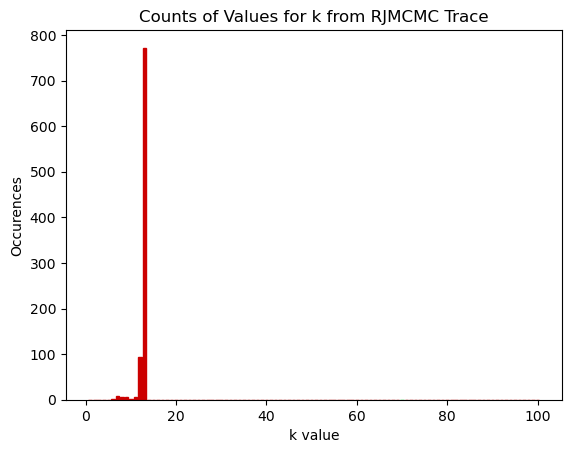

In [267]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=PyPlot.bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[k_real].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

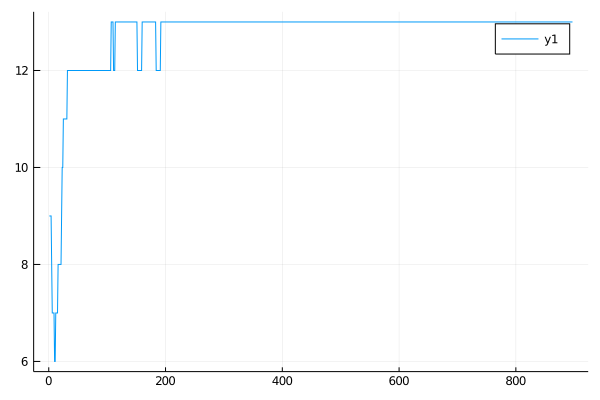

In [268]:
Plots.plot(ks)

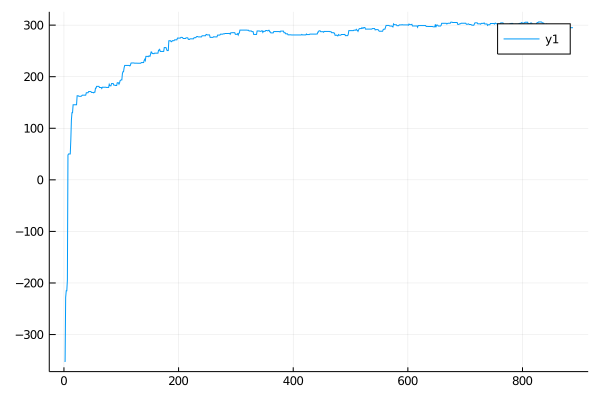

In [269]:
scores = [get_score(traces[i]) for i=1:length(traces)]
Plots.plot(scores[10:length(scores)])
#print(length(scores))

In [102]:
#Try Dynamic Plotting

anim = @animate for i ∈ 1:runs
    colors = ["lightblue" for i=1:k_range]
    colors[k_real] = "lightgreen"
    colors[ks[i]] = "red"
    Plots.histogram(
        ks[1:i], 
        bins=1:k_range+1,
        fillcolor=colors),
        title="Estimated Marginal Posterior Distribution of k",
        xlabel="k: Number of Hidden Nodes",
        ylabel="Occurences",
        legend=false
    )
end

gif(anim, "anim_fps20000.gif", fps = 20000)

LoadError: syntax: unexpected ")"

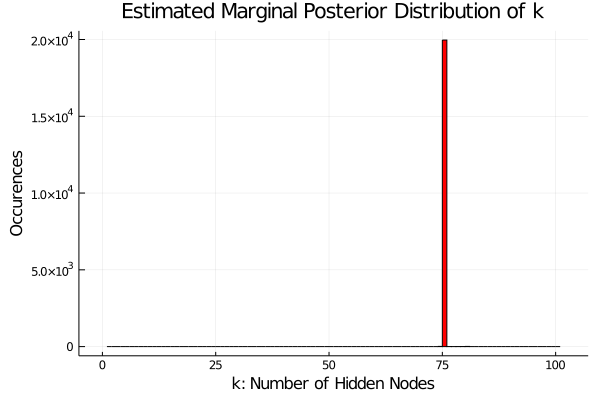

In [68]:
colors = ["lightblue" for i=1:k_range]
colors[k_real] = "lightgreen"
colors[ks[length(ks)]] = "red"
p4 = Plots.histogram(
    ks, 
    bins=1:k_range+1, 
    fillcolor=colors, 
    title="Estimated Marginal Posterior Distribution of k",
    xlabel="k: Number of Hidden Nodes",
    ylabel="Occurences",
    legend=false
)


In [81]:
#Fixed Network Time: Figure out which k is actually best

#Return a Flexible Network
function model(k::Int) 
    return Chain(
        Dense(2, k, σ),
        Dense(k, 1, σ))
end;

num_params(model) = sum(length, Flux.params(model)) 

round4(x) = round(x, digits=4)

penalty(m) = sum(abs2, Flux.params(m)[1]) + sum(abs2, Flux.params(m)[2]) + sum(abs2, Flux.params(m)[3])
loss(y_hat, y) = Flux.Losses.mse(y_hat, y) #+ penalty(m)

function getdata(x,y)
    # Reshape Data in order to flatten each image into a linear array
    xtrain = Flux.flatten(x)

    # One-hot-encode the labels
    ytrain = Flux.flatten(y_real)

    # Batching
    train_data = Flux.Data.DataLoader(xtrain, ytrain, batchsize=N, shuffle=true)

    return train_data
end

y_hat = (model(6))(x)
test_model = model(6)
#println(Flux.params(test_model)[1])
#println(Flux.params(test_model)[2])
#println(Flux.params(test_model)[3])
#println(Flux.params(test_model)[4])
print(lossa(y_hat, y_real, model(6)))

function eval_loss_accuracy(x, y, net)
    return loss(net(x), y)
end

function train(x,y,m,epochs)
    losses = []
    
    # Load Data
    train_data = getdata(x,y)

    # Construct model
    loss(x,y) = Flux.Losses.mse(m(x), y) + penalty(m)
    
    ## Training
    opt = Flux.Optimise.ADAM()

    for i=1:epochs
        Flux.train!(loss, Flux.params(m), train_data, opt)
        loss1 = eval_loss_accuracy(x,y,m)
        push!(losses,loss1)
        #println(Flux.params(m))
    end
    return m, losses
end

UndefVarError: UndefVarError: lossa not defined

In [67]:
training_runs = 500
a,b,c,d,e = 10, 30, 50, 70, 90

m1 = model(a)
m1_trained, losses1 = train(x, y_real, m1, training_runs);

In [68]:
m2 = model(b)
m2_trained, losses2 = train(x, y_real, m2, training_runs);

In [69]:
m3 = model(c)
m3_trained, losses3 = train(x, y_real, m3, training_runs);

In [70]:
m4 = model(d)
m4_trained, losses4 = train(x, y_real, m4, training_runs);

In [71]:
m5 = model(e)
m5_trained, losses5 = train(x, y_real, m5, training_runs);

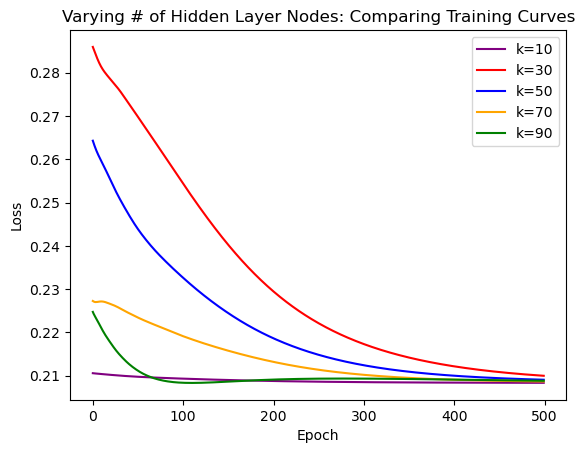

PyObject <matplotlib.legend.Legend object at 0x7fc2b103e490>

In [72]:
PyPlot.plot(losses1, color="purple", label="k=$a")
PyPlot.plot(losses2, color="red", label="k=$b")
PyPlot.plot(losses3, color="blue", label="k=$c")
PyPlot.plot(losses4, color="orange", label="k=$d")
PyPlot.plot(losses5, color="green", label="k=$e")
PyPlot.title("Varying # of Hidden Layer Nodes: Comparing Training Curves")
PyPlot.xlabel("Epoch")
PyPlot.ylabel("Loss")
PyPlot.legend()

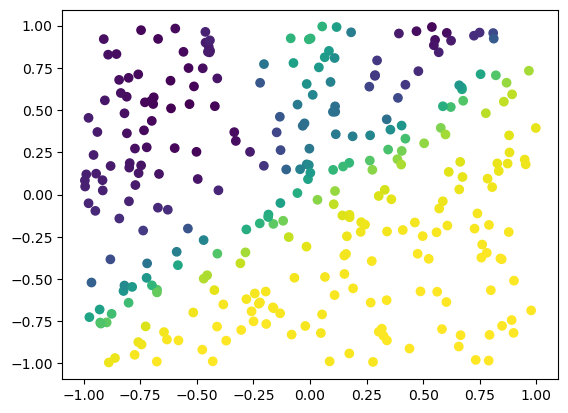

PyObject <matplotlib.collections.PathCollection object at 0x7fc0555fc190>

In [270]:
best_i = 1
for i=1:length(traces)
    test_trace = traces[i]
    test_score = get_score(test_trace)
    if test_score > get_score(traces[best_i]) 
        best_i = i
        #print(test_score)
    end
    #println("Epoch $i Score: $test_score")
end

Q = 100
y_prime = zeros(length(y_real))

for j=1:Q
    rand_i = rand((1:length(traces)))
    #print(rand_i)
    test_trace = traces[rand_i]
    tWₕ = test_trace[:Wₕ]
    tWₒ = test_trace[:Wₒ]
    tbₕ = test_trace[:bₕ]
    tbₒ = test_trace[:bₒ]
    tk = test_trace[:k]
    #println(tk)

    y_test = Flux.σ.(G(x,tWₕ,tbₕ,tWₒ,tbₒ,tk)[1,:])
    y_prime += y_test .* (1/Q)
    #println(euclidean(y_test, y_real))
end

plot_data(x_raw,y_prime)

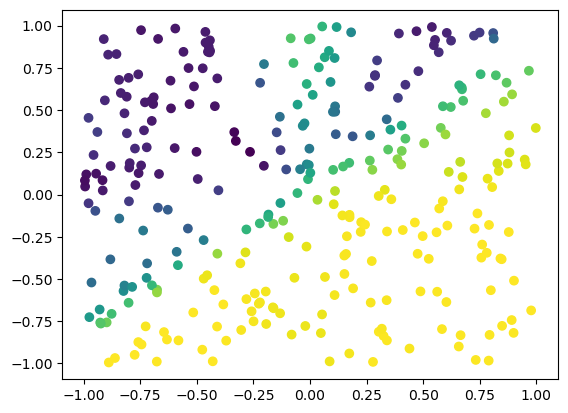

PyObject <matplotlib.collections.PathCollection object at 0x7fc055962710>

In [271]:
plot_data(x_raw,y_real)

In [272]:
print(best_i)
best_trace = traces[best_i];

837

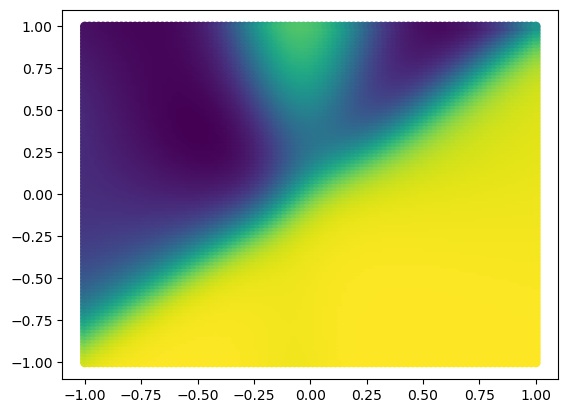

PyObject <matplotlib.collections.PathCollection object at 0x7fc0552a2450>

In [273]:
function tracegrid(trace, low=-1.0, high=1.0)
    d=2
    n=100
    r = range(low, high, length = n)
    
    #Neural Net Parameters
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]

    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z = Flux.σ.(G(grid2,Wₕ,bₕ,Wₒ,bₒ,k))[1,:]
    plot_data(grid_raw, z)
end

tracegrid(best_trace)

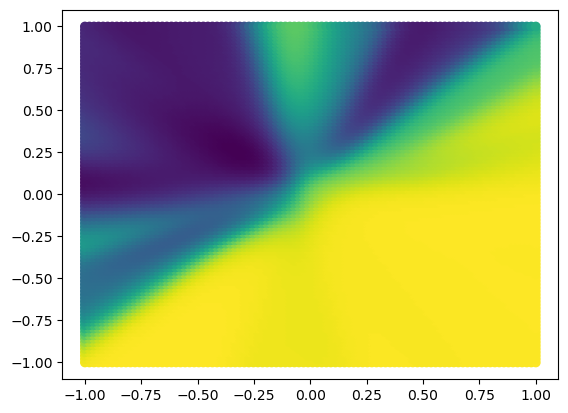

PyObject <matplotlib.collections.PathCollection object at 0x7fc05518e850>

In [275]:
function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-1.0,1.0)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = Flux.σ.(G(grid2.*10,Wₕ,bₕ,Wₒ,bₒ,k_real))[1,:]
plot_data(grid_raw, z)